In [1]:
import sys
sys.path.append("../") # Make module visible across folders

#### Import Modules

In [2]:
from transformers import BertTokenizer
from tokenizers.implementations import BertWordPieceTokenizer

from re import sub

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset

from typing import List, Tuple

from transformer.module.transformer import Transformer

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Train and Save the Tokenizer

In [3]:
train_data = "./train_data/ChatbotData.csv"
train_data_csv = pd.read_csv(train_data)

tokenizer = BertWordPieceTokenizer(lowercase=False, strip_accents=False)

# tokenizer.train(
#     files=train_data,
#     vocab_size=2**14,
#     min_frequency=2,
#     special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "[SOS]", "[EOS]"],
# )

# tokenizer.save_model("train_data/")

tokenizer = BertTokenizer.from_pretrained("train_data/vocab.txt", do_basic_tokenize=False)
tokenizer.vocab_size

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2004: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


15124

#### Set the Maximum Length of the Sequence, Get the Index of the `SOS`, `EOS`, `PAD`

In [4]:
max_length: int = 40

SOS = tokenizer.get_vocab()["[SOS]"]
EOS = tokenizer.get_vocab()["[EOS]"]
PAD = tokenizer.get_vocab()["[PAD]"]

print(SOS, EOS, PAD)

5 6 0


#### Remove Punctuations, Integer Encoding, Padding

In [5]:
questions = []
for sentence in train_data_csv["Q"]:
    sentence = sub(pattern=r"([?.!,])", repl=r" \1", string=sentence)
    sentence = sentence.strip()
    encoded_sentence = tokenizer.encode(sentence)
    encoded_sentence = encoded_sentence[1:-1]
    sentence = torch.IntTensor(encoded_sentence) # Encoder's input. No need to add SOS or EOS tokens.
    padding = nn.ZeroPad1d((0, max_length - 1 - sentence.shape[0]))(sentence)
    questions.append(padding.tolist())

questions = torch.IntTensor(questions)

answers = []
for sentence in train_data_csv["A"]:
    sentence = sub(pattern=r"([?.!,])", repl=r" \1", string=sentence)
    sentence = sentence.strip()
    encoded_sentence = tokenizer.encode(sentence)
    encoded_sentence = encoded_sentence[1:-1]
    sentence = torch.IntTensor([SOS] + encoded_sentence + [EOS]) # Decoder's input And Output. Decoder's input only contains SOS token and Output only contains EOS token.
    padding = nn.ZeroPad1d((0, max_length - sentence.shape[0]))(sentence)
    answers.append(padding.tolist())

answers = torch.IntTensor(answers)

# print(questions[:5], answers[:5])

#### Define `batch_size`, Make Several Datasets, Load with DataLoader

In [6]:
batch_size: int = 128

# QADataset in GitHub
# Link: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv


class QADataset(Dataset):
    def __init__(self, questions: torch.IntTensor, answers: torch.IntTensor) -> None:
        self.inputs = questions
        self.dec_inputs = answers[:, :-1]
        self.outputs = answers[:, 1:]

    def __len__(self) -> int:
        return len(self.inputs)

    def __getitem__(self, idx: int) -> Tuple[dict, dict]:
        return {"inputs": self.inputs[idx], "dec_inputs": self.dec_inputs[idx]}, {
            "outputs": self.outputs[idx]
        }


dataset = QADataset(questions, answers)

QA_train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
)

QA_validation_dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=False,
)

#### Set the Hyperparameter of the `Transformer` Model

In [7]:
encoder_vocab_size = tokenizer.vocab_size
decoder_vocab_size = tokenizer.vocab_size
pad_token = PAD
num_layers: int = 2
d_model: int = 256
num_heads: int = 8
max_len: int = max_length - 1
dff: int = 512
dropout: float = 0.1
device = torch.device(
    "mps" if torch.backends.mps.is_available() else "cpu"
)  # if CPU is used, you should remove .to(device) in all train and validation datasets otherwise error will be occurred due to different placeholder storage.
print(encoder_vocab_size, decoder_vocab_size)

15124 15124


#### Set the Parameter of the `Transformer` Model

In [8]:
model = Transformer(
    pad_token=pad_token,
    encoder_vocab_size=encoder_vocab_size,
    decoder_vocab_size=decoder_vocab_size,
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    max_len=max_len,
    dff=dff,
    dropout=dropout,
    device=device,
).to(device=device)

#### The Number of Parameters

In [9]:
def count_parameters(model: Transformer) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

14266132

#### Initialize the Weights

In [10]:
def initialize_weights(model) -> None:
    if hasattr(model, "weight") and model.weight.dim() > 1:
        nn.init.kaiming_uniform_(model.weight.data) # Use Kaiming uniform due to ReLU activation

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (embedding): TransformerEmbedding(
      (token_embedding): Embedding(15124, 256)
      (positional_encoding): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): MultiHeadAttention(
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (layer_norm1): LayerNorm()
        (dropout1): Dropout(p=0.1, inplace=False)
        (ffnn): PositionWiseFeedForward(
          (weight_tensor1): 

#### Make `TransformerScheduler`

In [11]:
class TransformerScheduler(Optimizer):
    """
    Custom Scheduler for Transformer which was introduced from the original paper "Attention is all you need, 2017".

    Parameters:
        optimizer: Optimizer
            optimizer for model training.
        d_model: int, required
            the embed dimension of the model.
        warmup_steps: int, optional (default=4000)
            boundary step between linear increase and proportional decrease.

    Returns:
        lr: float
            corresponding learning rate.
    """
    def __init__(
        self,
        optimizer: Optimizer,
        d_model: int,
        warmup_steps: int = 4000, # Paper-based value
    ) -> None:
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def get_lr(self, steps: int) -> float:
        scale = self.d_model**-0.5
        if steps < self.warmup_steps:
            lr = scale * (steps + 1) * (self.warmup_steps**-1.5)
        else:
            lr = scale * ((steps + 1) ** -0.5)
        return lr

    def step(self, steps: int) -> None:
        lr = self.get_lr(steps)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

#### Set the Parameters required for optimizer and criterion(loss).

In [12]:
lr: float = 1e-5 # There was no initial rate written in the based paper, I manually set it to 1e-5. You can adjust it if you want.
betas: Tuple[float, float] = [0.9, 0.98]
eps: float = 1e-9
epochs: int = 70
clip: float = 1.0
total_steps: int = 0

optimizer = Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
scheduler = TransformerScheduler(optimizer=optimizer, d_model=d_model) # Adam Optimizer is wrapped in the `TransformerScheduler` Class.
criterion = CrossEntropyLoss(ignore_index=PAD)

#### Train and Evaluate the Model

In [13]:
def train(
    epoch: int,
    epochs: int,
    model: Transformer,
    iterator: DataLoader,
    optimizer: Optimizer,
    scheduler: TransformerScheduler,
    criterion: CrossEntropyLoss,
    clip: int,
) -> float:
    model.train()
    training_total_loss: float = 0.0
    previous_loss: float = 0.0
    global total_steps

    for i, (all_inputs, outputs) in enumerate(iterator):

        optimizer.zero_grad()

        logits = model(
            encoder_input=all_inputs["inputs"].to(device=device),
            decoder_input=all_inputs["dec_inputs"].to(device=device),
        )
        logits = logits.contiguous().view(-1, logits.shape[-1]).to(device=device)
        outputs = outputs["outputs"].view(-1).type(torch.LongTensor).to(device=device)

        loss = criterion(input=logits, target=outputs).to(device=device)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=clip)

        optimizer.step()

        total_steps += 1
        scheduler.step(steps=total_steps)

        training_total_loss += loss.item()

        if max(previous_loss, loss.item()) == loss.item():
            print(
                f"\033[0m\033[1mEpoch: [{epoch + 1}/{epochs}], Progress: {i / len(iterator) * 100:.2f} %, Steps: {total_steps}, Current Learning Rate: {scheduler.get_lr(total_steps):.7f}, \033[91mTrain Loss: {loss.item():.3f}"
            )
            previous_loss = loss.item()
        else:
            print(
                f"\033[0m\033[1mEpoch: [{epoch + 1}/{epochs}], Progress: {i / len(iterator) * 100:.2f} %, Steps: {total_steps}, Current Learning Rate: {scheduler.get_lr(total_steps):.7f}, \033[96mTrain Loss: {loss.item():.3f}"
            )
            previous_loss = loss.item()

    return training_total_loss / len(iterator)

In [14]:
def evaluate(
    model: Transformer,
    iterator: DataLoader,
    criterion: CrossEntropyLoss,
) -> float:
    model.eval()
    validation_total_loss: float = 0.0

    with torch.no_grad():
        for _, (all_inputs, outputs) in enumerate(iterator):
            logits = model(
                encoder_input=all_inputs["inputs"].to(device=device),
                decoder_input=all_inputs["dec_inputs"].to(device=device),
            )
            logits = logits.contiguous().view(-1, logits.shape[-1]).to(device=device)
            outputs = (
                outputs["outputs"].view(-1).type(torch.LongTensor).to(device=device)
            )

            loss = criterion(input=logits, target=outputs).to(device=device)
            validation_total_loss += loss.item()

    return validation_total_loss / len(iterator)

In [15]:
y_train, y_eval = [], []  # Lists for Visualization
best_validation_loss: float = float("inf")

for epoch in range(epochs):
    print("\033[1m\033[92m=" * 42 + f" Epoch [{epoch + 1}/{epochs}] " + "=" * 42)
    train_loss = train(
        epoch=epoch,
        epochs=epochs,
        model=model,
        iterator=QA_train_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        clip=clip,
    )
    y_train.append(train_loss)

    print("\033[1m\033[93mComputing Validation Loss...")
    validation_loss = evaluate(
        model=model,
        iterator=QA_validation_dataloader,
        criterion=criterion,
    )
    y_eval.append(validation_loss)

    print(
        f"\033[1mEpoch {epoch + 1} Completed! Average Train Loss: {train_loss:.3f}, Average Validation Loss: {validation_loss:.3f}"
    )

    if validation_loss <= best_validation_loss:
        best_validation_loss = validation_loss
        f: str = "best_model/best_model.pt"
        torch.save(obj=model.state_dict(), f=f)
        print(f"Best Model saved in {f}.")

    torch.mps.empty_cache()

========================================== Epoch [1/70] ==========================================
Epoch: [1/70], Progress: 0.00 %, Steps: 1, Current Learning Rate: 0.0000005, Train Loss: 26.408
Epoch: [1/70], Progress: 1.08 %, Steps: 2, Current Learning Rate: 0.0000007, Train Loss: 25.281
Epoch: [1/70], Progress: 2.15 %, Steps: 3, Current Learning Rate: 0.0000010, Train Loss: 26.905
Epoch: [1/70], Progress: 3.23 %, Steps: 4, Current Learning Rate: 0.0000012, Train Loss: 26.992
Epoch: [1/70], Progress: 4.30 %, Steps: 5, Current Learning Rate: 0.0000015, Train Loss: 26.470
Epoch: [1/70], Progress: 5.38 %, Steps: 6, Current Learning Rate: 0.0000017, Train Loss: 26.524
Epoch: [1/70], Progress: 6.45 %, Steps: 7, Current Learning Rate: 0.0000020, Train Loss: 26.202
Epoch: [1/70], Progress: 7.53 %, Steps: 8, Current Learning Rate: 0.0000022, Train Loss: 26.317
Epoch: [1/70], Progress: 8.60 %, Steps: 9, Current Learning Rate: 0.0000025, Train Loss: 26.137
Epoch: [1/70], Progress: 9.68 %, Step

#### Loss Visualization

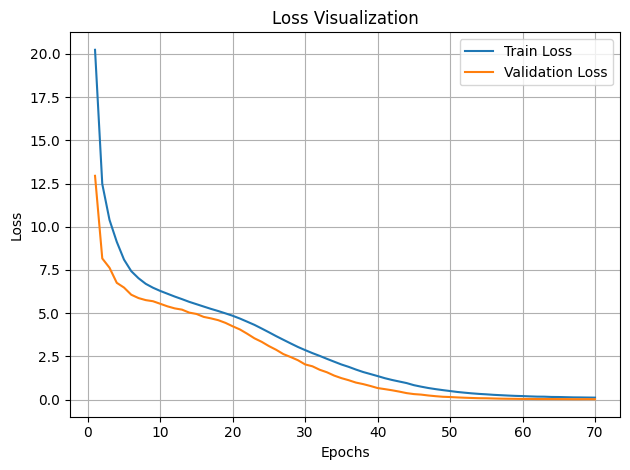

In [16]:
def visualization(x: List[int], y_train: List[float], y_eval: List[float]) -> plt.plot:
    plt.plot(x, y_train, label="Train Loss")
    plt.plot(x, y_eval, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.legend()
    plt.title("Loss Visualization")
    plt.tight_layout()
    plt.grid()

    return plt.show()

visualization(x=list(range(1, epochs + 1)), y_train=y_train, y_eval=y_eval)

#### Preprocess User Input and Predict the Data

In [20]:
def preprocess_user_input(sentence: str) -> torch.IntTensor:
    sentence = sub(pattern=r"([?.!,])", repl=r" \1", string=sentence)
    sentence = sentence.strip()
    encoded_sentence = tokenizer.encode(sentence)
    sentence_id = torch.IntTensor(encoded_sentence)
    
    return sentence_id

In [23]:
def predict(sentence: str) -> None:
    print(f"Q: {sentence}")

    model.load_state_dict(
        torch.load("best_model/best_model.pt")
    )  # Call the best validation loss model.
    model.eval()

    with torch.no_grad():
        sentence = preprocess_user_input(sentence=sentence)
        sentence = sentence.unsqueeze(dim=0).to(device=device)  # Encoder's input

        output = (
            torch.IntTensor([SOS]).unsqueeze(dim=0).to(device=device)
        )  # Decoder's input

        for _ in range(max_len):
            predictions = model(encoder_input=sentence, decoder_input=output)
            predictions = predictions[:, -1:, :]
            predicted_id = torch.argmax(input=predictions, dim=-1)
            predicted_id = predicted_id[-1]  # Take only last portion of prediction

            if torch.equal(
                input=torch.IntTensor([predicted_id]).to(device=device),
                other=torch.IntTensor([EOS]).to(device=device),
            ):
                break

            output = torch.cat(
                [output, torch.IntTensor([[predicted_id]]).to(device=device)], dim=1
            )

        output = output[:, 1:]  # Exclude SOS token
        prediction = torch.squeeze(input=output, dim=0)
        predicted_sentence = tokenizer.decode(prediction)

    print(f"A: {predicted_sentence}")

predict("힘들어")

Q: 힘들어
A: 조금만 더 힘내세요.
